In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import pickle

import numpy as np
from lightgbm import LGBMRegressor

In [2]:
# topix銘柄を東証のファイルから取得
df_company = pd.read_excel('data/data_j.xls', sheet_name=0, index_col=0)
df_company = df_company.reset_index()
df_company = df_company.rename(columns={'コード':'code', '銘柄名':'name', '市場・商品区分':'market', '33業種区分':'cat33', '17業種区分':'cat17', '規模区分':'scale'})
df_company = df_company[['code','name', 'market', 'cat33', 'cat17', 'scale']]
df_company = df_company[df_company['scale'].str.contains('TOPIX')]
df_company = df_company[~df_company['scale'].str.contains('TOPIX Small ')]

In [3]:
df_company

,code,name,market,cat33,cat17,scale
19,1332,日本水産,プライム（内国株式）,水産・農林業,食品,TOPIX Mid400
20,1333,マルハニチロ,プライム（内国株式）,水産・農林業,食品,TOPIX Mid400
61,1414,ショーボンドホールディングス,プライム（内国株式）,建設業,建設・資材,TOPIX Mid400
62,1417,ミライト・ホールディングス,プライム（内国株式）,建設業,建設・資材,TOPIX Mid400
162,1605,ＩＮＰＥＸ,プライム（内国株式）,鉱業,エネルギー資源,TOPIX Mid400
...,...,...,...,...,...,...
4158,9962,ミスミグループ本社,プライム（内国株式）,卸売業,商社・卸売,TOPIX Mid400
4171,9983,ファーストリテイリング,プライム（内国株式）,小売業,小売,TOPIX Large70
4172,9984,ソフトバンクグループ,プライム（内国株式）,情報・通信業,情報通信・サービスその他,TOPIX Core30
4174,9987,スズケン,プライム（内国株式）,卸売業,商社・卸売,TOPIX Mid400


In [5]:
# get unique cat
codes = df_company.code.to_numpy()
cat33s = df_company.cat33.to_numpy()
cat17s = df_company.cat17.to_numpy()

# make dict
cat33_list = list(set(cat33s))
cat17_list = list(set(cat17s))
cat33_cat2num = {}
cat33_num2cat = {}
cat17_cat2num = {}
cat17_num2cat = {}
for i in range(len(cat33_list)):
    cat33_cat2num[cat33_list[i]] = i
    cat33_num2cat[i] = cat33_list[i]
for i in range(len(cat17_list)):
    cat17_cat2num[cat17_list[i]] = i
    cat17_num2cat[i] = cat17_list[i]

# convert code to cat
cat_dict = {}
for i in range(len(codes)):
    cat_dict[codes[i]] = [cat33_cat2num[cat33s[i]], cat17_cat2num[cat17s[i]]]


In [6]:
# get date
with open('data/closes_dict.pickle', 'rb') as f:
    closes_dict = pickle.load(f)

dates = []
for i in range(0, 23):
    for j in range(1, 12):
        date_20 = '20{:02}-{:02}-20'.format(i, j)
        dates.append(date_20)
    
closes_dict['date'] = dates

In [7]:
df_fs = pd.read_pickle('data/df_fs.pickle')

In [8]:
# get close df
df_closes = pd.DataFrame(closes_dict)

In [9]:
# macroの特徴量作成
df_macro = df_closes[df_closes.date <= '2022-06-20'][['date', '^N225', 'USDJPY=X', 'CL=F', '^TNX']]
for i in [3, 6, 12, 24, 36, 48]:
    df_macro['^N225_rel_{}'.format(i)] = df_macro['^N225'] / df_macro['^N225'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['USDJPY=X_rel_{}'.format(i)] = df_macro['USDJPY=X'] / df_macro['USDJPY=X'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['CL=F_rel_{}'.format(i)] = df_macro['CL=F'] / df_macro['CL=F'].transform(lambda x: x.rolling(i, 1).mean())
    df_macro['^TNX_rel_{}'.format(i)] = df_macro['^TNX'] / df_macro['^TNX'].transform(lambda x: x.rolling(i, 1).mean())

In [10]:
target_codes = [1332, 1333, 1414, 1417, 1605, 1721, 1801, 1802, 1803, 1808, 1812, 1820, 1860, 1878, 1893, 1911, 1925, 1928, 1944, 1951, 1959, 1963, 2002, 2127, 2175, 2181, 2201, 2206, 2212, 2229, 2264, 2267, 2269, 2270, 2282, 2331, 2371, 2412, 2413, 2427, 2432, 2433, 2492, 2501, 2502, 2503, 2531, 2579, 2587, 2593, 2607, 2651, 2670, 2768, 2784, 2801, 2802, 2809, 2810, 2811, 2815, 2871, 2875, 2897, 2914, 3003, 3038, 3064, 3086, 3088, 3092, 3099, 3101, 3105, 3107, 3116, 3141, 3197, 3231, 3288, 3289, 3291, 3349, 3360, 3382, 3391, 3401, 3402, 3405, 3407, 3436, 3549, 3563, 3591, 3626, 3635, 3659, 3697, 3765, 3769, 3774, 3861, 3863, 3880, 3923, 3941, 3994, 4004, 4005, 4021, 4042, 4043, 4045, 4061, 4062, 4063, 4088, 4091, 4114, 4118, 4151, 4182, 4183, 4185, 4186, 4188, 4202, 4203, 4204, 4205, 4206, 4208, 4272, 4307, 4324, 4401, 4403, 4443, 4452, 4502, 4503, 4506, 4507, 4516, 4519, 4521, 4523, 4527, 4528, 4530, 4534, 4536, 4540, 4543, 4544, 4552, 4568, 4578, 4581, 4587, 4612, 4613, 4631, 4661, 4665, 4666, 4676, 4681, 4684, 4686, 4689, 4704, 4716, 4732, 4739, 4751, 4755, 4768, 4887, 4901, 4902, 4911, 4912, 4919, 4921, 4922, 4927, 4967, 5019, 5020, 5021, 5076, 5101, 5105, 5108, 5110, 5201, 5214, 5232, 5233, 5301, 5332, 5333, 5334, 5401, 5406, 5411, 5444, 5463, 5471, 5486, 5631, 5703, 5706, 5711, 5713, 5714, 5801, 5802, 5901, 5929, 5938, 5947, 5991, 6005, 6028, 6098, 6103, 6113, 6134, 6136, 6141, 6146, 6178, 6201, 6268, 6273, 6301, 6302, 6305, 6326, 6361, 6367, 6370, 6383, 6395, 6406, 6417, 6436, 6448, 6457, 6460, 6465, 6471, 6472, 6473, 6479, 6481, 6501, 6502, 6503, 6504, 6506, 6532, 6586, 6592, 6594, 6645, 6674, 6701, 6702, 6723, 6724, 6728, 6752, 6753, 6754, 6755, 6758, 6762, 6770, 6806, 6841, 6845, 6849, 6856, 6857, 6861, 6869, 6902, 6920, 6923, 6925, 6951, 6952, 6954, 6963, 6965, 6967, 6971, 6976, 6981, 6988, 7011, 7012, 7013, 7164, 7167, 7180, 7181, 7182, 7186, 7201, 7202, 7203, 7205, 7211, 7240, 7259, 7261, 7267, 7269, 7270, 7272, 7276, 7282, 7309, 7313, 7337, 7453, 7458, 7459, 7476, 7518, 7532, 7550, 7616, 7649, 7701, 7730, 7731, 7732, 7733, 7735, 7741, 7747, 7751, 7752, 7780, 7832, 7846, 7911, 7912, 7936, 7947, 7951, 7956, 7966, 7974, 7984, 7988, 8001, 8002, 8012, 8015, 8031, 8035, 8053, 8056, 8058, 8060, 8086, 8088, 8111, 8113, 8129, 8136, 8227, 8233, 8252, 8253, 8267, 8273, 8279, 8282, 8283, 8303, 8304, 8306, 8308, 8309, 8316, 8331, 8334, 8354, 8355, 8359, 8369, 8377, 8382, 8385, 8410, 8411, 8418, 8439, 8473, 8570, 8572, 8591, 8593, 8595, 8601, 8604, 8630, 8697, 8725, 8750, 8766, 8795, 8801, 8802, 8804, 8830, 8876, 8905, 9001, 9003, 9005, 9006, 9007, 9008, 9009, 9020, 9021, 9022, 9024, 9031, 9041, 9042, 9044, 9045, 9048, 9064, 9065, 9072, 9076, 9086, 9101, 9104, 9107, 9142, 9143, 9147, 9201, 9202, 9301, 9364, 9401, 9404, 9409, 9432, 9433, 9434, 9435, 9449, 9468, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9513, 9531, 9532, 9533, 9601, 9602, 9613, 9627, 9684, 9697, 9706, 9719, 9735, 9744, 9766, 9783, 9831, 9832, 9843, 9861, 9962, 9983, 9984, 9987, 9989]

In [11]:
df_all = pd.DataFrame()
for code in target_codes:
    # 個別株のデータの取り出し
    df_i = df_closes[df_closes.date <= '2022-06-20'][['date', code, '^N225']]

    # カテゴリ
    df_i[['cat33', 'cat17']] = cat_dict[1332]

    # 株価の推移
    df_i['stock_pri'] = df_i[code]
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        df_i['stock_pri_{}'.format(i)] = df_i['stock_pri'].shift(i) / df_i['stock_pri']

    # 日経平均に対する値動き
    df_i['rel_pri'] = df_i['stock_pri'] / df_i['^N225']
    for i in range(0, 12):
        df_i['rel_ret_{}'.format(i)] = df_i['rel_pri'].shift(i) / df_i['rel_pri'].shift(i+1)
        df_i['rel_ret_{}'.format(i)] = df_i['rel_pri'].shift(i) / df_i['rel_pri'].shift(i+1)

    # センチメント
    for i in [3, 6, 12, 24, 36, 48]:
        df_i['stock_pri_rel_{}'.format(i)] = df_i['stock_pri'] / df_i['stock_pri'].transform(lambda x: x.rolling(i, 1).mean())
        df_i['rel_pri_rel_{}'.format(i)] = df_i['rel_pri'] / df_i['rel_pri'].transform(lambda x: x.rolling(i, 1).mean())


    df_i['target'] = np.log(df_i['rel_pri'].shift(-3)/df_i['rel_pri'])
    df_i = df_i.drop(code, axis=1)
    df_i = df_i.drop('^N225', axis=1)
    df_i['code_num'] = code

    df_i = pd.merge(df_i, df_macro, on='date')
    df_i = df_i[df_i.date >= '2005']

    df_all = pd.concat([df_all, df_i])

In [12]:
df_fs = df_fs.reset_index()

In [25]:
df_fs['date_code'] = df_fs['year'].astype(str).str[:5] + '06-20-' + df_fs['code'].astype(str)
df_all['date_code'] = df_all['date'] + '-' + df_all['code_num'].astype(str)

In [27]:
df_merge = pd.merge(df_fs, df_all, left_on='date_code', right_on = 'date_code')

In [35]:
list(df_merge.columns)[30:]

['Total Assets bs',
 'Common Stock bs',
 'Other Current Assets bs',
 'Retained Earnings bs',
 'Other Liab bs',
 'Treasury Stock bs',
 'Other Assets bs',
 'Cash bs',
 'Total Current Liabilities bs',
 'Deferred Long Term Asset Charges bs',
 'Other Stockholder Equity bs',
 'Property Plant Equipment bs',
 'Total Current Assets bs',
 'Long Term Investments bs',
 'Net Tangible Assets bs',
 'Net Receivables bs',
 'Long Term Debt bs',
 'Inventory bs',
 'Accounts Payable bs',
 'Good Will bs',
 'Short Long Term Debt bs',
 'Investments cf',
 'Change To Liabilities cf',
 'Total Cashflows From Investing Activities cf',
 'Net Borrowings cf',
 'Total Cash From Financing Activities cf',
 'Change To Operating Activities cf',
 'Net Income cf',
 'Change In Cash cf',
 'Repurchase Of Stock cf',
 'Effect Of Exchange Rate cf',
 'Total Cash From Operating Activities cf',
 'Depreciation cf',
 'Other Cashflows From Investing Activities cf',
 'Dividends Paid cf',
 'Change To Inventory cf',
 'Change To Account Re

# 機械学習

In [29]:
# Numpy Version
def build_model():
    # Do feel free to experiment with different models here!
    model = LGBMRegressor(n_estimators = 1000, num_leaves = 500, max_depth = 10, learning_rate = 0.09)
    return model

In [36]:
fs_features =  ['Research Development pnl',
 'Effect Of Accounting Charges pnl',
 'Income Before Tax pnl',
 'Minority Interest pnl',
 'Net Income pnl',
 'Selling General Administrative pnl',
 'Gross Profit pnl',
 'Ebit pnl',
 'Operating Income pnl',
 'Other Operating Expenses pnl',
 'Interest Expense pnl',
 'Extraordinary Items pnl',
 'Non Recurring pnl',
 'Other Items pnl',
 'Income Tax Expense pnl',
 'Total Revenue pnl',
 'Total Operating Expenses pnl',
 'Cost Of Revenue pnl',
 'Total Other Income Expense Net pnl',
 'Discontinued Operations pnl',
 'Net Income From Continuing Ops pnl',
 'Net Income Applicable To Common Shares pnl',
 'Intangible Assets bs',
 'Capital Surplus bs',
 'Total Liab bs',
 'Total Stockholder Equity bs',
 'Minority Interest bs',
 'Other Current Liab bs',
 'Total Assets bs',
 'Common Stock bs',
 'Other Current Assets bs',
 'Retained Earnings bs',
 'Other Liab bs',
 'Good Will bs',
 'Treasury Stock bs',
 'Other Assets bs',
 'Cash bs',
 'Total Current Liabilities bs',
 'Deferred Long Term Asset Charges bs',
 'Other Stockholder Equity bs',
 'Property Plant Equipment bs',
 'Total Current Assets bs',
 'Long Term Investments bs',
 'Net Tangible Assets bs',
 'Short Term Investments bs',
 'Net Receivables bs',
 'Long Term Debt bs',
 'Inventory bs',
 'Accounts Payable bs',
 'Investments cf',
 'Change To Liabilities cf',
 'Total Cashflows From Investing Activities cf',
 'Net Borrowings cf',
 'Total Cash From Financing Activities cf',
 'Net Income cf',
 'Change In Cash cf',
 'Repurchase Of Stock cf',
 'Effect Of Exchange Rate cf',
 'Total Cash From Operating Activities cf',
 'Depreciation cf',
 'Other Cashflows From Investing Activities cf',
 'Dividends Paid cf',
 'Change To Inventory cf',
 'Change To Account Receivables cf',
 'Other Cashflows From Financing Activities cf',
 'Change To Netincome cf',
 'Capital Expenditures cf',
 'Change To Operating Activities cf',
 'Issuance Of Stock cf',
 'Short Long Term Debt bs',
 'Deferred Long Term Liab bs']

In [40]:
df_merge[fs_features] = df_merge[fs_features].astype(float)

In [45]:
df_merge

,year,code,Research Development pnl,Effect Of Accounting Charges pnl,Income Before Tax pnl,Minority Interest pnl,Net Income pnl,Selling General Administrative pnl,Gross Profit pnl,Ebit pnl,...,CL=F_rel_24,^TNX_rel_24,^N225_rel_36,USDJPY=X_rel_36,CL=F_rel_36,^TNX_rel_36,^N225_rel_48,USDJPY=X_rel_48,CL=F_rel_48,^TNX_rel_48
0,2022-03-31 00:00:00,1332,NaN,NaN,2.715400e+10,1.879900e+10,1.727500e+10,8.215700e+10,1.110800e+11,2.707700e+10,...,1.633327,2.189561,1.031318,1.218325,1.819203,2.072813,1.061807,1.219547,1.792893,1.706721
1,2021-03-31 00:00:00,1332,NaN,NaN,2.256000e+10,1.835200e+10,1.445200e+10,1.072090e+11,1.271770e+11,1.808000e+10,...,1.496136,1.088691,1.243867,1.013485,1.343341,0.785128,1.279225,1.009199,1.346479,0.728819
2,2020-03-31 00:00:00,1332,NaN,NaN,2.266000e+10,1.914800e+10,1.476800e+10,1.088190e+11,1.337980e+11,2.283600e+10,...,0.749205,0.327115,1.044526,0.973670,0.742412,0.311211,1.096630,0.977396,0.765113,0.321186
3,2019-03-31 00:00:00,1332,NaN,NaN,2.460400e+10,1.983200e+10,1.537900e+10,1.152500e+11,1.387260e+11,2.168700e+10,...,0.953490,0.759453,1.057777,0.977663,1.018173,0.826651,1.077662,0.955884,1.070033,0.857518
4,2021-03-31 00:00:00,1333,NaN,NaN,1.056000e+10,2.416300e+10,5.778000e+09,9.999400e+10,1.162030e+11,1.620900e+10,...,1.496136,1.088691,1.243867,1.013485,1.343341,0.785128,1.279225,1.009199,1.346479,0.728819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,2018-03-31 00:00:00,9987,NaN,NaN,2.876500e+10,6.730000e+08,1.882000e+10,1.681440e+11,1.875120e+11,1.973700e+10,...,1.245683,1.270833,1.168246,0.981806,1.316377,1.316202,1.219373,0.989913,1.128449,1.294179
1976,2021-03-31 00:00:00,9989,NaN,NaN,3.718800e+10,NaN,2.532900e+10,1.208790e+11,1.585500e+11,3.734600e+10,...,1.496136,1.088691,1.243867,1.013485,1.343341,0.785128,1.279225,1.009199,1.346479,0.728819
1977,2020-03-31 00:00:00,9989,NaN,NaN,3.464800e+10,NaN,2.369200e+10,1.179960e+11,1.546190e+11,3.660600e+10,...,0.749205,0.327115,1.044526,0.973670,0.742412,0.311211,1.096630,0.977396,0.765113,0.321186
1978,2019-03-31 00:00:00,9989,NaN,NaN,3.507000e+10,NaN,2.393300e+10,1.116710e+11,1.471780e+11,3.523400e+10,...,0.953490,0.759453,1.057777,0.977663,1.018173,0.826651,1.077662,0.955884,1.070033,0.857518


In [41]:
features = ['cat33', 'cat17', 'stock_pri', 'stock_pri_1', 'stock_pri_2',
       'stock_pri_3', 'stock_pri_4', 'stock_pri_5', 'stock_pri_6',
       'stock_pri_7', 'stock_pri_8', 'stock_pri_9', 'stock_pri_10',
       'stock_pri_11', 'stock_pri_12', 'rel_pri', 'rel_ret_0', 'rel_ret_1',
       'rel_ret_2', 'rel_ret_3', 'rel_ret_4', 'rel_ret_5', 'rel_ret_6',
       'rel_ret_7', 'rel_ret_8', 'rel_ret_9', 'rel_ret_10', 'rel_ret_11',
       'stock_pri_rel_3', 'rel_pri_rel_3', 'stock_pri_rel_6', 'rel_pri_rel_6',
       'stock_pri_rel_12', 'rel_pri_rel_12', 'stock_pri_rel_24',
       'rel_pri_rel_24', 'stock_pri_rel_36', 'rel_pri_rel_36',
       'stock_pri_rel_48', 'rel_pri_rel_48', 'code_num', '^N225',
       'USDJPY=X', 'CL=F', '^TNX', '^N225_rel_3', 'USDJPY=X_rel_3',
       'CL=F_rel_3', '^TNX_rel_3', '^N225_rel_6', 'USDJPY=X_rel_6',
       'CL=F_rel_6', '^TNX_rel_6', '^N225_rel_12', 'USDJPY=X_rel_12',
       'CL=F_rel_12', '^TNX_rel_12', '^N225_rel_24', 'USDJPY=X_rel_24',
       'CL=F_rel_24', '^TNX_rel_24', '^N225_rel_36', 'USDJPY=X_rel_36',
       'CL=F_rel_36', '^TNX_rel_36', '^N225_rel_48', 'USDJPY=X_rel_48',
       'CL=F_rel_48', '^TNX_rel_48']

In [50]:
corrs = {}
for i in range(20, 22):
    start = '20{:02}'.format(i)
    end = '20{:02}'.format(i+1)
    df_train = df_merge[df_merge.date < start]
    df_val = df_merge[(df_merge.date >= start) & (df_merge.date < end)]
    train_X, train_y = df_train[features+fs_features], df_train['target'] 
    val_X, val_y = df_val[features+fs_features], df_val['target'] 

    # make models
    model = build_model()
    model.fit( train_X, train_y)
    pred = model.predict(val_X)
    df_val['pred'] = pred

    df_pred = df_val[['pred', 'target']].dropna()
    corrs[start] = np.corrcoef(df_pred['pred'], df_pred['target'])[0][1]

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_47392/2643647469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


In [51]:
corrs

{'2020': -0.04334450153014004, '2021': -0.03871404267672819}

Text(0.5, 1.0, 'prediction of stock return to Nikkei (2022)\n correlation: 0.1440')

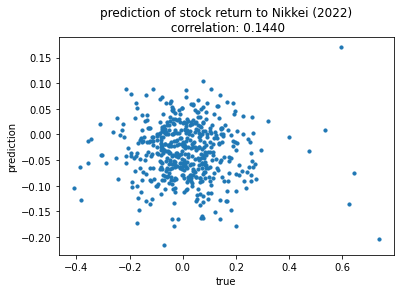

In [52]:
plt.scatter(df_val['target'],df_val['pred'],  s=10)
plt.ylabel('prediction')
plt.xlabel('true')
plt.title('prediction of stock return to Nikkei (2022)\n correlation: 0.1440')
# plt.savefig('corr_2022.png')

In [43]:
# make models
model = build_model()
model.fit( train_X, train_y)
pred = model.predict(val_X)
df_val['pred'] = pred

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_26297/2153178893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


# 銘柄選択

In [96]:
df_train = df_all[df_all.date < '2022-04-20']
df_val = df_all[df_all.date == '2022-06-20']
train_X, train_y = df_train[features], df_train['target'] 
val_X, val_y = df_val[features], df_val['target'] 

In [97]:
# make models
model = build_model()
model.fit( train_X, train_y)
pred = model.predict(val_X)
df_val['pred'] = pred

/var/folders/jk/74x9q4ms33j_6fbn_1sfb7w40000gn/T/ipykernel_26297/2153178893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['pred'] = pred


In [104]:
df_result = pd.merge(df_val, df_company, left_on='code_num', right_on='code')

In [105]:
df_result.to_csv('data/macro_ranking.csv')